Yeast! Woohoo!

In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2
from nn.preprocess import *
from nn.nn import NeuralNetwork
from nn.io import *

### Read in data

In [3]:
positive = read_text_file('data/rap1-lieb-positives.txt')
negative = read_fasta_file('data/yeast-upstream-1k-negative.fa')

In [4]:
len(positive[0])

17

In [5]:
#making negative sequences the same length as positive seqs: 
#randomly selecting 17 bp from each negative seq
new_length = 17
np.random.seed(13)
negative_shortened = []

for seq in negative:
    new_start = np.random.randint(0, len(seq)-new_length)
    negative_shortened += [seq[new_start:new_start+new_length]]


In [6]:
len(positive), len(negative_shortened)

(137, 3163)

### Sample sequences

Randomly samples the positive samples with replacement to match number of negative sequences.

In [7]:
all_seqs = positive+negative_shortened

#1 = positive, 0 = negative
all_labels = [1]*len(positive)+[0]*len(negative_shortened)

sampled_seqs, sampled_labels = sample_seqs(all_seqs, all_labels)

In [8]:
Counter(sampled_labels)

Counter({0: 3163, 1: 3163})

### One hot encode sequences

In [9]:
seqs_one_hot = one_hot_encode_seqs(sampled_seqs)

In [10]:
seqs_one_hot[0]

array([0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.])

### Split data into training and validation sets

80% training, 20% validation

In [11]:
#shuffle
np.random.seed(1)
idxs = np.arange(len(seqs_one_hot))
np.random.shuffle(idxs)
seqs_shuffled = np.array(seqs_one_hot,dtype=object)[idxs]
labels_shuffled = np.array(sampled_labels,dtype=object)[idxs]

#split
split_on = round(len(seqs_one_hot)*.8)

seqs_train = seqs_shuffled[:split_on]
labels_train = labels_shuffled[:split_on]

seqs_val = seqs_shuffled[split_on:]
labels_val = labels_shuffled[split_on:]

seqs_train.shape, labels_train.shape, seqs_val.shape, labels_val.shape

((5061, 68), (5061,), (1265, 68), (1265,))

### Train NN:

-I chose sigmoid as the activation function because this is a classification problem, and my inputs/outputs are binary.

-I chose binary cross entropy as the loss function because we want a probability distribution (probability of positive or negative) as the output.

-I didn't find that the output size of the first layer mattered much (but sizes larger than 64 made the model very slow). The second layer output is a 1D array because the labels are 1D.

-I tuned the model (see below) and chose the parameters that gave the best validation loss. The learning rate of 0.1 seemed to have the strongest effect on the outcome. The loss decays pretty rapidly so I definitely could have similar results with a lower number of epochs than in the best model.

-I tested smaller values for epochs than the autoencoder because the sigmoid activation makes the model slower overall. 

In [56]:
hyperparam_tune = []

for lr in [0.01, 0.001, 0.0001]:
    for epoch in [10, 25, 50]:
        for batch_size in [100, 500, 1000]:

            model = NeuralNetwork(nn_arch =  [{'input_dim': 68, 'output_dim': 32, 'activation': 'sigmoid'},
                                  {'input_dim': 32, 'output_dim': 1, 'activation': 'sigmoid'}],
                          lr = lr, seed = 1, batch_size = batch_size, 
                          epochs = epoch, loss_function='mse')

            per_epoch_loss_train, per_epoch_loss_val = model.fit(seqs_train, labels_train, seqs_val, labels_val)

            final_train_loss = min(per_epoch_loss_train)
            final_val_loss = min(per_epoch_loss_val)

            hyperparam_tune += [[lr, epoch, batch_size, final_train_loss, final_val_loss]]


In [57]:
df = pd.DataFrame(hyperparam_tune)
df.columns = ['LR', 'num_epochs', 'batch_size', 'train_MSE', 'val_MSE']

In [58]:
df.sort_values('val_MSE').head(5)

,LR,num_epochs,batch_size,train_MSE,val_MSE
6,0.01,50,100,0.085526,0.083373
3,0.01,25,100,0.173256,0.170240
7,0.01,50,500,0.217373,0.216204
0,0.01,10,100,0.220362,0.218216
8,0.01,50,1000,0.228983,0.228040


### Plotting training and validation loss for best model:

In [59]:
def plot_loss(per_epoch_loss_train, per_epoch_loss_val):
    
    plt.plot(per_epoch_loss_train, label='training')
    plt.plot(per_epoch_loss_val, label='validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (BCE)')
    plt.legend()
    
    plt.show()

In [60]:
lr = 0.01
batch_size = 100
epoch = 50


model = NeuralNetwork(nn_arch =  [{'input_dim': 68, 'output_dim': 32, 'activation': 'sigmoid'},
                                  {'input_dim': 32, 'output_dim': 1, 'activation': 'sigmoid'}],
                          lr = lr, seed = 13, batch_size = batch_size, 
                          epochs = epoch, loss_function='mse')

per_epoch_loss_train, per_epoch_loss_val =  model.fit(seqs_train, labels_train, seqs_val, labels_val)

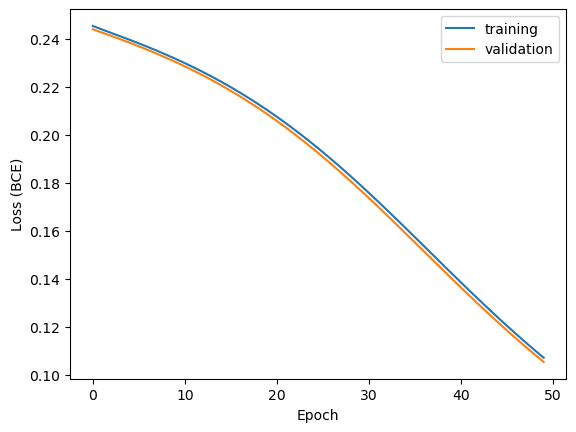

In [61]:
plot_loss(per_epoch_loss_train, per_epoch_loss_val)

### Accuracy of classifier on validation data

In [62]:
pred = model.predict(seqs_val)

In [63]:
#convert predictions to binary values like the labels
pred_binary = np.where(pred.squeeze() < .5, 0, 1)

In [64]:
#accuracy
len(np.where(labels_val == pred_binary)[0])/len(labels_val)

0.9873517786561264

In [65]:
#just checking
print(pred_binary[0:20])
print(labels_val[0:20])

[0 1 1 1 0 1 0 1 0 0 0 0 1 1 1 0 1 0 1 0]
[0 1 1 1 0 1 0 1 0 0 0 0 1 1 1 0 1 0 1 0]
